## import and load data

In [15]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder

df = pd.read_csv("../input/h-and-m-filtering/out.csv", dtype={"article_id": str})
test_df = pd.read_csv('../input/h-and-m-personalized-fashion-recommendations/sample_submission.csv').drop("prediction", axis=1)
articles=pd.read_csv("../input/h-and-m-personalized-fashion-recommendations/articles.csv")


## dataset

In [16]:
df["t_dat"] = pd.to_datetime(df["t_dat"])

active_articles = df.groupby("article_id")["t_dat"].max().reset_index()
active_articles = active_articles[active_articles["t_dat"] >= "2019-09-01"].reset_index()

df = df[df["article_id"].isin(active_articles["article_id"])].reset_index(drop=True)
df["week"] = (df["t_dat"].max() - df["t_dat"]).dt.days // 7
# df["week"].value_counts()

article_ids = np.concatenate([["placeholder"], np.unique(df["article_id"].values)])

le_article = LabelEncoder()
le_article.fit(article_ids)
df["article_id"] = le_article.transform(df["article_id"])


In [17]:
def create_dataset(df, week):
    hist_df = df[(df["week"] > week) & (df["week"] <= week + WEEK_HIST_MAX)]
    hist_df = hist_df.groupby("customer_id").agg({"article_id": list, "week": list}).reset_index()
    hist_df.rename(columns={"week": 'week_history'}, inplace=True)
    
    target_df = df[df["week"] == week]
    target_df = target_df.groupby("customer_id").agg({"article_id": list}).reset_index()
    target_df.rename(columns={"article_id": "target"}, inplace=True)
    target_df["week"] = week
    
    return target_df.merge(hist_df, on="customer_id", how="left")


WEEK_HIST_MAX = 5
val_weeks = [0]
train_weeks = [1, 2, 3, 4]


val_df = pd.concat([create_dataset(df, w) for w in val_weeks]).reset_index(drop=True)
train_df = pd.concat([create_dataset(df, w) for w in train_weeks]).reset_index(drop=True)

In [18]:
from torch.utils.data import Dataset, DataLoader
import torch
from tqdm import tqdm

class HMDataset(Dataset):
    def __init__(self, df, seq_len, is_test=False):
        self.df = df.reset_index(drop=True)
        self.seq_len = seq_len
        self.is_test = is_test
    
    def __len__(self):
        return self.df.shape[0]
    
    def __getitem__(self, index):
        row = self.df.iloc[index]
        
        if self.is_test:
            target = torch.zeros(2).float()
        else:
            target = torch.zeros(len(article_ids)).float()
            for t in row.target:
                target[t] = 1.0
            
        article_hist = torch.zeros(self.seq_len).long()
        week_hist = torch.ones(self.seq_len).float()
        
        
        if isinstance(row.article_id, list):
            if len(row.article_id) >= self.seq_len:
                article_hist = torch.LongTensor(row.article_id[-self.seq_len:])
                week_hist = (torch.LongTensor(row.week_history[-self.seq_len:]) - row.week)/WEEK_HIST_MAX/2
            else:
                article_hist[-len(row.article_id):] = torch.LongTensor(row.article_id)
                week_hist[-len(row.article_id):] = (torch.LongTensor(row.week_history) - row.week)/WEEK_HIST_MAX/2
                
        return article_hist, week_hist, target

## utils

In [19]:
def adjust_lr(optimizer, epoch):
    if epoch < 1:
        lr = 5e-5
    elif epoch < 6:
        lr = 1e-3
    elif epoch < 9:
        lr = 1e-4
    else:
        lr = 1e-5

    for p in optimizer.param_groups:
        p['lr'] = lr
    return lr
    
def get_optimizer(net):
    optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, net.parameters()), lr=3e-4, betas=(0.9, 0.999),
                                 eps=1e-08)
    return optimizer



def read_data(data):
    return tuple(d.cuda() for d in data[:-1]), data[-1].cuda()

In [20]:
def dcg_score(y_true, y_score, k=12):
    order = np.argsort(y_score)[::-1]
    y_true = np.take(y_true, order[:k])

    gains = 2 ** y_true - 1
    discounts = np.log2(np.arange(len(y_true)) + 2)
    return np.sum(gains / discounts)

def ndcg_score(y_true, y_score, k=12):
    best_dcg = dcg_score(y_true, y_true, k)
    if best_dcg == 0:
        return 0

    dcg = dcg_score(y_true, y_score, k)
    return dcg / best_dcg

def calc_map(topk_preds, target_array, k=12):
    metric = []
    tp, fp = 0, 0
    
    for pred in topk_preds:
        if target_array[pred]:
            tp += 1
            metric.append(tp/(tp + fp))
        else:
            fp += 1
            
    return np.sum(metric) / min(k, target_array.sum())

## Models

In [21]:
SEQ_LEN = 16
BS = 256
NW = 8

val_dataset = HMDataset(val_df, SEQ_LEN)
val_loader = DataLoader(val_dataset, batch_size=BS, shuffle=False, num_workers=NW,
                          pin_memory=False, drop_last=False)

In [22]:
import torch.nn as nn
import torch.nn.functional as F

class HMModel(nn.Module):
    def __init__(self, article_shape):
        super(HMModel, self).__init__()
        
        self.article_emb = nn.Embedding(article_shape[0], embedding_dim=article_shape[1])
        
        self.article_likelihood = nn.Parameter(torch.zeros(article_shape[0]), requires_grad=True)
        self.top = nn.Sequential(nn.Conv1d(3, 32, kernel_size=1), nn.LeakyReLU(),
                                 nn.Conv1d(32, 8, kernel_size=1), nn.LeakyReLU(),
                                 nn.Conv1d(8, 1, kernel_size=1))
        
    def forward(self, inputs):
        article_hist, week_hist = inputs[0], inputs[1]
        x = self.article_emb(article_hist)
        x = F.normalize(x, dim=2)
        
        x = x@F.normalize(self.article_emb.weight).T
        
        x, indices = x.max(axis=1)
        x = x.clamp(1e-3, 0.999)
        x = -torch.log(1/x - 1)
        
        max_week = week_hist.unsqueeze(2).repeat(1, 1, x.shape[-1]).gather(1, indices.unsqueeze(1).repeat(1, week_hist.shape[1], 1))
        max_week = max_week.mean(axis=1).unsqueeze(1)
        
        x = torch.cat([x.unsqueeze(1), max_week,
                       self.article_likelihood[None, None, :].repeat(x.shape[0], 1, 1)], axis=1)
        
        x = self.top(x).squeeze(1)
        return x
    
    
model = HMModel((len(le_article.classes_), 512))
model = model.cuda()

## Train and validate

In [23]:
import sys


def validate(model, val_loader, k=12):
    model.eval()
    
    tbar = tqdm(val_loader, file=sys.stdout)
    
    maps = []
    ndcgs = []
    
    with torch.no_grad():
        for idx, data in enumerate(tbar):
            inputs, target = read_data(data)

            logits = model(inputs)

            _, indices = torch.topk(logits, k, dim=1)

            indices = indices.detach().cpu().numpy()
            target = target.detach().cpu().numpy()
            y_score = logits.sigmoid().detach().cpu().numpy()
            
            for i in range(y_score.shape[0]):
                ndcg = ndcg_score(target[i], y_score[i], k)
                ndcgs.append(ndcg)

            for i in range(indices.shape[0]):
                maps.append(calc_map(indices[i], target[i]))
        
    
    return np.mean(maps), np.mean(ndcgs)

In [24]:
def dice_loss(y_pred, y_true):
    y_pred = y_pred.sigmoid()
    intersect = (y_true*y_pred).sum(axis=1)
    
    return 1 - (intersect/(intersect + y_true.sum(axis=1) + y_pred.sum(axis=1))).mean()


def train(model, train_loader, val_loader, epochs):
    np.random.seed(SEED)
    
    optimizer = get_optimizer(model)
    scaler = torch.cuda.amp.GradScaler()

    criterion = torch.nn.BCEWithLogitsLoss()
    
    for e in range(epochs):
        print("="*30)
        print(f"Current Epoch {e+1}")
        print("-"*30)
        model.train()
        tbar = tqdm(train_loader, file=sys.stdout)
        
        lr = adjust_lr(optimizer, e)
        
        loss_list = []

        for idx, data in enumerate(tbar):
            inputs, target = read_data(data)

            optimizer.zero_grad()
            
            with torch.cuda.amp.autocast():
                logits = model(inputs)
                loss = criterion(logits, target) + dice_loss(logits, target)
            
            
            #loss.backward()
            scaler.scale(loss).backward()
            #optimizer.step()
            scaler.step(optimizer)
            scaler.update()
            
            loss_list.append(loss.detach().cpu().item())
            
            avg_loss = np.round(100*np.mean(loss_list), 4)

            tbar.set_description()
            
        avg_map, avg_ndcg = validate(model, val_loader, k=12)

        log_text = f"Epoch {e+1}\nTrain Loss: {avg_loss} Validation MAP: {avg_map} Validation NDCG: {avg_ndcg}\n"
            
        print(log_text)

    return model


MODEL_NAME = "exp001"
SEED = 0


train_dataset = HMDataset(train_df, SEQ_LEN)
train_loader = DataLoader(train_dataset, batch_size=BS, shuffle=True, num_workers=NW,
                          pin_memory=False, drop_last=True)

model = train(model, train_loader, val_loader, epochs=5)

Current Epoch 1
------------------------------
100%|██████████| 262/262 [01:00<00:00,  4.35it/s]
Epoch 1
Train Loss: 160.0275 Validation MAP: 0.01904666104966966 Validation NDCG: 0.024428355738223516

Current Epoch 2
------------------------------
100%|██████████| 262/262 [01:06<00:00,  3.96it/s]
Epoch 2
Train Loss: 101.7848 Validation MAP: 0.022725288326209587 Validation NDCG: 0.03294375384685563

Current Epoch 3
------------------------------
100%|██████████| 262/262 [01:06<00:00,  3.96it/s]
Epoch 3
Train Loss: 100.0845 Validation MAP: 0.022880787021420795 Validation NDCG: 0.0338491022433474

Current Epoch 4
------------------------------
100%|██████████| 262/262 [01:06<00:00,  3.97it/s]
Epoch 4
Train Loss: 99.9667 Validation MAP: 0.023971786993542868 Validation NDCG: 0.03560009045157068

Current Epoch 5
------------------------------
100%|██████████| 262/262 [01:05<00:00,  3.98it/s]
Epoch 5
Train Loss: 99.9161 Validation MAP: 0.024152087387061965 Validation NDCG: 0.03574194157095492

### Final data

In [25]:
def create_test_dataset(test_df):
    week = -1
    test_df["week"] = week
    
    hist_df = df[(df["week"] > week) & (df["week"] <= week + WEEK_HIST_MAX)]
    hist_df = hist_df.groupby("customer_id").agg({"article_id": list, "week": list}).reset_index()
    hist_df.rename(columns={"week": 'week_history'}, inplace=True)
    
    
    return test_df.merge(hist_df, on="customer_id", how="left")

test_df = create_test_dataset(test_df)

In [26]:
test_df["article_id"].isnull().mean()

0.865299785711162

In [27]:
test_ds = HMDataset(test_df, SEQ_LEN, is_test=True)
test_loader = DataLoader(test_ds, batch_size=BS, shuffle=False, num_workers=NW,
                          pin_memory=False, drop_last=False)


def inference(model, loader, k=12):
    model.eval()
    
    tbar = tqdm(loader, file=sys.stdout)
    
    preds = []
    
    with torch.no_grad():
        for idx, data in enumerate(tbar):
            inputs, target = read_data(data)

            logits = model(inputs)

            _, indices = torch.topk(logits, k, dim=1)

            indices = indices.detach().cpu().numpy()
            target = target.detach().cpu().numpy()

            for i in range(indices.shape[0]):
                preds.append(" ".join(list(le_article.inverse_transform(indices[i]))))
        
    
    return preds


test_df["prediction"] = inference(model, test_loader)

100%|██████████| 5360/5360 [07:26<00:00, 12.01it/s]


In [31]:
test_df.head()

,customer_id,week,article_id,week_history,prediction
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,-1,[604],[2],568601043 915526001 909370001 918292001 751471...
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,-1,NaN,NaN,915526001 909370001 918292001 751471001 751471...
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,-1,[2953],[1],794321007 915526001 909370001 918292001 751471...
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,-1,NaN,NaN,915526001 909370001 918292001 751471001 751471...
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,-1,NaN,NaN,915526001 909370001 918292001 751471001 751471...


In [32]:
filtered_df = test_df[['customer_id', 'prediction']]

In [33]:

customer_id = '00040239317e877c77ac6e79df42eb2633ad38fcac09fc0094e549180ddc201c'
customer_predictions = filtered_df[filtered_df['customer_id'] == customer_id]['prediction']
print(customer_predictions.index[0])
prediction_str= filtered_df['prediction'].iloc[customer_predictions.index[0]]

predicted_article_ids = list(map(int, prediction_str.split()))
matching_articles = articles[articles['article_id'].isin(predicted_article_ids)]


90


In [34]:
import matplotlib.pyplot as plt
path = "../input/h-and-m-personalized-fashion-recommendations/images"
rcmnds_img=matching_articles

def article_recommend_img():
    fig = plt.figure(figsize=(20, 10))
    for i, item in enumerate(rcmnds_img['article_id']):
        item = '0' + str(item)
        sub = item[:3]
        image = path + "/"+ sub + "/"+ item +".jpg"
        image = plt.imread(image)
        ax = fig.add_subplot(1, 12, i+1)  
        ax.imshow(image)
        ax.axis('off')  

    plt.show()  

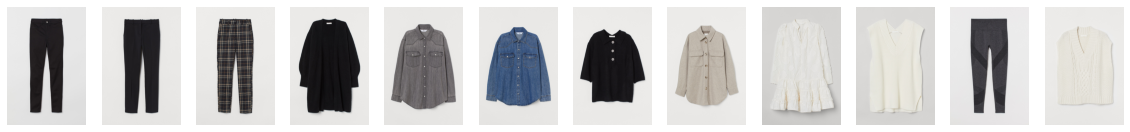

In [35]:
article_recommend_img()